/tmp/ipykernel_434520/3921851062.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features].fillna(0, inplace=True)


Epoch [1/50], Loss: 0.0255
Epoch [2/50], Loss: 0.0151
Epoch [3/50], Loss: 0.0104
Epoch [4/50], Loss: 0.0082
Epoch [5/50], Loss: 0.0071
Epoch [6/50], Loss: 0.0070
Epoch [7/50], Loss: 0.0064
Epoch [8/50], Loss: 0.0059
Epoch [9/50], Loss: 0.0055
Epoch [10/50], Loss: 0.0054
Epoch [11/50], Loss: 0.0057
Epoch [12/50], Loss: 0.0051
Epoch [13/50], Loss: 0.0049
Epoch [14/50], Loss: 0.0049
Epoch [15/50], Loss: 0.0048
Epoch [16/50], Loss: 0.0045
Epoch [17/50], Loss: 0.0046
Epoch [18/50], Loss: 0.0047
Epoch [19/50], Loss: 0.0044
Epoch [20/50], Loss: 0.0042
Epoch [21/50], Loss: 0.0041
Epoch [22/50], Loss: 0.0041
Epoch [23/50], Loss: 0.0043
Epoch [24/50], Loss: 0.0039
Epoch [25/50], Loss: 0.0042
Epoch [26/50], Loss: 0.0037
Epoch [27/50], Loss: 0.0040
Epoch [28/50], Loss: 0.0036
Epoch [29/50], Loss: 0.0035
Epoch [30/50], Loss: 0.0037
Epoch [31/50], Loss: 0.0036
Epoch [32/50], Loss: 0.0036
Epoch [33/50], Loss: 0.0033
Epoch [34/50], Loss: 0.0034
Epoch [35/50], Loss: 0.0032
Epoch [36/50], Loss: 0.0033
E

findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

Epoch [50/50], Loss: 0.0027
MSE: 15939.6943, MAE: 81.4289


findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei
findfont: Generic family 'sans-serif' not foun

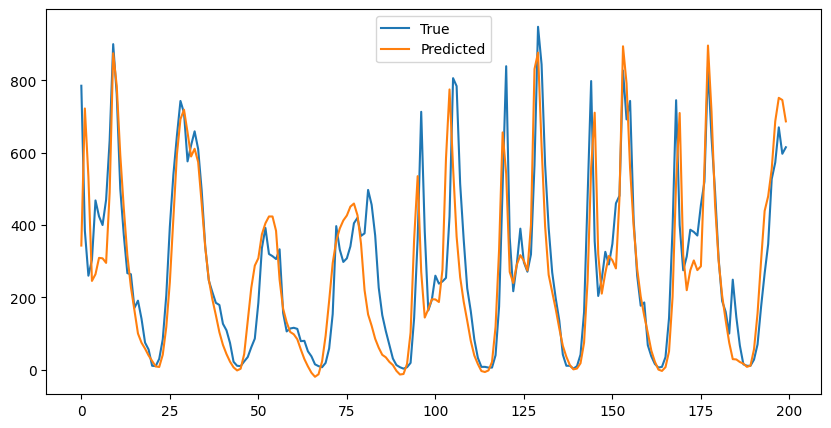

In [ ]:
# -*- coding: utf-8 -*-
"""
LSTM模型用于共享单车租赁预测
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.optim import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

# 解决画图中文显示问题
# plt.rcParams['font.sans-serif'] = ['SimHei']
# plt.rcParams['axes.unicode_minus'] = False

# 参数设置
look_back = 96  # 输入的历史时间步
epochs = 50  # 迭代次数
batch_size = 64  # 批量大小
input_dim = 9  # 输入特征数
hidden_dim = 64  # 隐藏层神经元数
num_layers = 2  # LSTM层数
dropout = 0.2  # Dropout
learn_rate = 0.0005  # 学习率

# 加载数据
# train_data = pd.read_csv('train_data.csv')
# test_data = pd.read_csv('test_data.csv')

data_path = r'../data/'
train_data = pd.read_csv(data_path + 'train_data.csv')
test_data = pd.read_csv(data_path + 'test_data.csv')

# 选择特征和目标列
features = ['season', 'yr', 'holiday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
target = 'cnt'

train_data[features].fillna(0, inplace=True)
train_data[target].fillna(0, inplace=True)


# 数据预处理：归一化
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

train_data[features] = scaler_features.fit_transform(train_data[features])
train_data[target] = scaler_target.fit_transform(train_data[[target]])
test_data[features] = scaler_features.transform(test_data[features])
test_data[target] = scaler_target.transform(test_data[[target]])

train_data[features] = train_data[features].fillna(train_data[features].mean())
test_data[features] = test_data[features].fillna(test_data[features].mean())


# 构建时间序列数据
def create_sequences(data, features, target, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[features].iloc[i:i + look_back].values)
        y.append(data[target].iloc[i + look_back])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, features, target, look_back)
X_test, y_test = create_sequences(test_data, features, target, look_back)

# 转换为 PyTorch Tensor 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# 数据加载器
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取最后时间步的输出
        return out

# 初始化模型
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1, num_layers=num_layers, dropout=dropout)
model = model.to(device)

# 初始化权重
def init_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)
            elif 'bias' in name:
                nn.init.zeros_(param)

model.apply(init_weights)

# 损失函数与优化器
criterion = nn.MSELoss()
optimizer = Adam(model.parameters(), lr=learn_rate)

# 梯度裁剪
def clip_gradients(model, max_norm=1.0):
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

# 训练
train_losses = []
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        if torch.isnan(loss):
            raise ValueError("Loss became NaN during training.")
        
        loss.backward()
        clip_gradients(model)
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {avg_loss:.4f}")

# 测试
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(y_batch.cpu().numpy())

# 反归一化
predictions = scaler_target.inverse_transform(np.array(predictions).reshape(-1, 1))
actuals = scaler_target.inverse_transform(np.array(actuals).reshape(-1, 1))

# 评估
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
print(f"MSE: {mse:.4f}, MAE: {mae:.4f}")

# 可视化结果
plt.figure(figsize=(10, 5))
plt.plot(actuals[:200], label="True")
plt.plot(predictions[:200], label="Predicted")
plt.legend()
plt.show()


In [14]:
print("Check NaN in Train Features:", train_data[features].isnull().sum())
print("Check NaN in Train Target:", train_data[target].isnull().sum())
print("Check Min/Max of Train Features:", train_data[features].min().min(), train_data[features].max().max())
print("Check Min/Max of Train Target:", train_data[target].min(), train_data[target].max())


Check NaN in Train Features: season        0
yr            0
holiday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
dtype: int64
Check NaN in Train Target: 0
Check Min/Max of Train Features: 0.0 1.0
Check Min/Max of Train Target: 0.0 1.0
